Import Required libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Data Preprocessing

In [7]:
df = pd.read_csv('space_mission_data.csv')

Printing first five rows

In [8]:
df.head()

,Unnamed: 0,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4324 entries, 0 to 4323
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      4324 non-null   int64 
 1   Organisation    4324 non-null   object
 2   Location        4324 non-null   object
 3   Date            4324 non-null   object
 4   Detail          4324 non-null   object
 5   Rocket_Status   4324 non-null   object
 6   Price           964 non-null    object
 7   Mission_Status  4324 non-null   object
dtypes: int64(1), object(7)
memory usage: 304.0+ KB


Checking for null values

In [10]:
df.isnull().sum()

Unnamed: 0           0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64

Drop columns 'Unnamed: 0' and 'Unnamed: 0.1'

In [11]:
df = df.drop(columns=[col for col in ['Unnamed: 0', 'Unnamed: 0.1'] if col in df.columns])

In [12]:
df.head()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


Convert Date to datetime so that month and year can be extracted from it for analysis

In [13]:

# Convert to datetime with UTC-aware parsing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

# Remove timezone info to make it timezone-naive (required for dt access)
df['Date'] = df['Date'].dt.tz_localize(None)

# Now it's safe to extract Month and Year
df['Month'] = df['Date'].dt.month_name()
df['Year'] = df['Date'].dt.year


In [14]:
# Remove any leading/trailing whitespace from Location
df['Location'] = df['Location'].astype(str).str.strip()

# Extract country (last comma-separated value)
df['Country'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notnull(x) else x)

# Extract the rest of the location (everything except the country)
df['Space_Centre_Name'] = df['Location'].apply(lambda x: ','.join(x.split(',')[:-1]).strip() if ',' in x else x)

print(df[['Space_Centre_Name', 'Country']].head(10))

                                   Space_Centre_Name     Country
0              LC-39A, Kennedy Space Center, Florida         USA
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...       China
2                           Pad A, Boca Chica, Texas         USA
3                   Site 200/39, Baikonur Cosmodrome  Kazakhstan
4                SLC-41, Cape Canaveral AFS, Florida         USA
5              LC-9, Taiyuan Satellite Launch Center       China
6                     Site 31/6, Baikonur Cosmodrome  Kazakhstan
7           LC-101, Wenchang Satellite Launch Center       China
8                SLC-40, Cape Canaveral AFS, Florida         USA
9                    LA-Y1, Tanegashima Space Center       Japan


Drop the 'location' column now

In [15]:
df = df.drop(columns=['Location'])

Convert datatype of Price column from Categorical to numeric

In [16]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [17]:
df['Price'].describe()

count    949.000000
mean     129.795237
std      143.220323
min        5.300000
25%       40.000000
50%       62.000000
75%      164.000000
max      450.000000
Name: Price, dtype: float64

<Axes: >

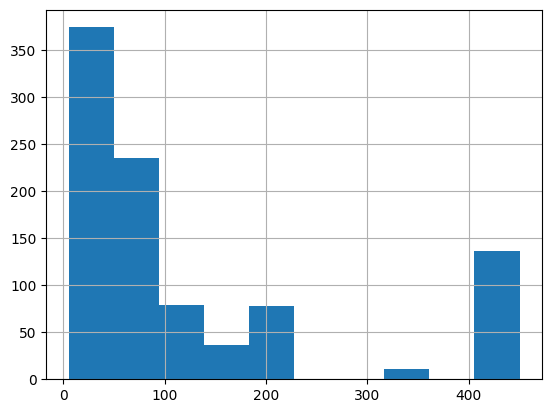

In [18]:
df['Price'].hist()

Price column is too much right skewed, so we will have to use median to fill null values

In [19]:
df['Price'].skew()

np.float64(1.5077937711635496)

 Fill null values in 'Price' with the median price for each country by taking median of prices of each country separately.

In [20]:
df['Price'] = df.groupby('Country')['Price'].transform(
    lambda x: x.fillna(x.median())
)

/Users/sakshamsahu/Documents/Imarticus/Space-Mission-Analytics/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/sakshamsahu/Documents/Imarticus/Space-Mission-Analytics/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/sakshamsahu/Documents/Imarticus/Space-Mission-Analytics/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/sakshamsahu/Documents/Imarticus/Space-Mission-Analytics/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/sakshamsahu/Documents/Imarticus/Space-Mission-Analytics/.venv/lib/python3.9/site-

In [21]:
df['Price'].isnull().sum()

np.int64(94)

The remaining nulls are likely from countries where all or almost all Price values are missing, so the median for those countries is itself null and cannot be used to fill missing values.
Hence, we will use overall median to fill those leftover 94 rows.

In [22]:
overall_median = df['Price'].median()
df['Price'] = df['Price'].fillna(overall_median)

In [23]:
df['Price'].isnull().sum()

np.int64(0)

In [24]:
df.head()

,Organisation,Date,Detail,Rocket_Status,Price,Mission_Status,Month,Year,Country,Space_Centre_Name
0,SpaceX,2020-08-07 05:12:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,August,2020.0,USA,"LC-39A, Kennedy Space Center, Florida"
1,CASC,2020-08-06 04:01:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,August,2020.0,China,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce..."
2,SpaceX,2020-08-04 23:57:00,Starship Prototype | 150 Meter Hop,StatusActive,109.00,Success,August,2020.0,USA,"Pad A, Boca Chica, Texas"
3,Roscosmos,2020-07-30 21:25:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,July,2020.0,Kazakhstan,"Site 200/39, Baikonur Cosmodrome"
4,ULA,2020-07-30 11:50:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,July,2020.0,USA,"SLC-41, Cape Canaveral AFS, Florida"


In [25]:
df.to_csv("space_mission_data_cleaned.csv", index=False)
